---
title: "Supervised Learning"
format:
    html: 
        toc: true
        code-fold: false
        embedded-resouces: true
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [176]:
# Import necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

exonerees_balanced = pd.read_csv('../../data/processed-data/exonerees_balanced.csv')
exonerees_balanced.head()

,last_name,first_name,age,sex,state,latitude,longitude,worst_crime_display,sentence,sentence_in_years,...,misconduct_in_interrogation_of_exoneree,perjury_by_official,prosecutor_lied_in_court,tag_sum,geocode_address,Race_orig,Label,County,State,Race
0,Abbott,Cinque,19.0,male,Illinois,41.819738,-87.756525,Drug Possession or Sale,Probation,0.0,...,0.0,0.0,0.0,7.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,NaN,Black
1,Abernathy,Christopher,17.0,male,Illinois,41.819738,-87.756525,Murder,Life without parole,100.0,...,1.0,0.0,0.0,10.0,"Cook County, Illinois, United States",White,Exonerated,Cook,NaN,White
2,Abrego,Eruby,20.0,male,Illinois,41.819738,-87.756525,Murder,90 years,90.0,...,1.0,1.0,0.0,9.0,"Cook County, Illinois, United States",Hispanic,Exonerated,Cook,NaN,NaN
3,Adams,Demetris,22.0,male,Illinois,41.819738,-87.756525,Drug Possession or Sale,1 year,1.0,...,0.0,0.0,0.0,7.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,NaN,Black
4,Adams,Kenneth,22.0,male,Illinois,41.819738,-87.756525,Murder,75 years,75.0,...,0.0,0.0,0.0,11.0,"Cook County, Illinois, United States",Black,Exonerated,Cook,NaN,Black


In [177]:
pd.crosstab(
    exonerees_balanced['Label'], exonerees_balanced['Race'],
    margins=True,
    normalize=True
)

Race,Black,Latino,Other,White,All
Label,,,,,
Exonerated,0.412636,0.000000,0.000000,0.046397,0.459033
Non-Exonerated,0.287266,0.090819,0.004936,0.157947,0.540967
All,0.699901,0.090819,0.004936,0.204344,1.000000


## Preprocessing

In [178]:
# Map 'Exonerated' to 1 and 'Non-Exonerated' to 0
exonerees_balanced['Label'] = exonerees_balanced['Label'].map({'Exonerated': 1, 'Non-Exonerated': 0})

# Rename the column to 'exonerated'
exonerees_balanced.rename(columns={'Label': 'Exonerated'}, inplace=True)
# Keep relevant features
data = exonerees_balanced[['Race', 'County', 'Exonerated']].copy()

# Preview the transformed data
print(data.head())



    Race County  Exonerated
0  Black   Cook           1
1  White   Cook           1
2    NaN   Cook           1
3  Black   Cook           1
4  Black   Cook           1


## One Hot encoding

In [179]:
# Perform one-hot encoding without dropping any category
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
encoded_features = encoder.fit_transform(data[['Race', 'County']])

# Create a DataFrame for the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Race', 'County']))

# Concatenate encoded features with the original dataset
data = pd.concat([data.drop(columns=['Race', 'County']), encoded_df], axis=1)

# Preview the data
data.head()



,Exonerated,Race_Black,Race_Latino,Race_Other,Race_White,Race_nan,County_Adams,County_Bond,County_Boone,County_Brown,...,County_Sangamon,County_St. Clair,County_Stephenson,County_Tazewell,County_Vermilion,County_Washington,County_Will,County_Williamson,County_Winnebago,County_Woodford
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## splitting data

In [180]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data.drop(columns=['Exonerated'])  # Drop the target column
y = data['Exonerated']  # Target column

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (876, 63)
Test set shape: (220, 63)


## model: logisitic regression

Logistic Regression - Accuracy: 0.90, Precision: 0.90, Recall: 0.89, F1 Score: 0.90, ROC-AUC: 0.95


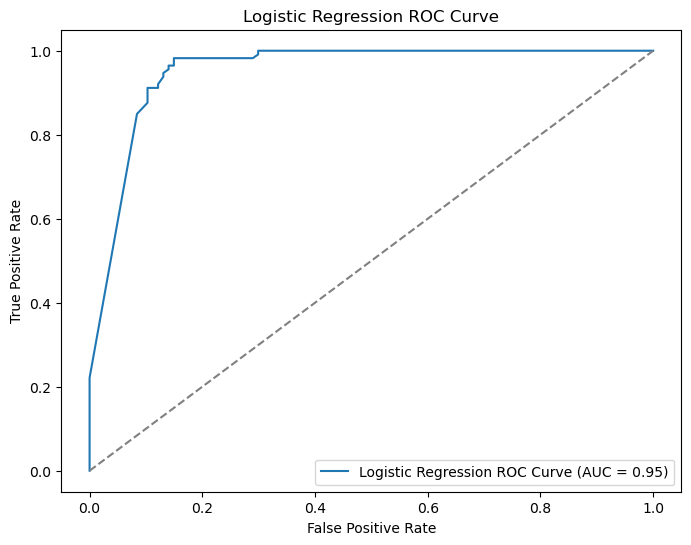

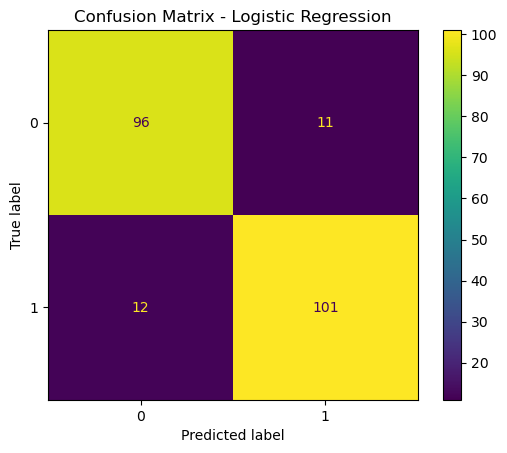

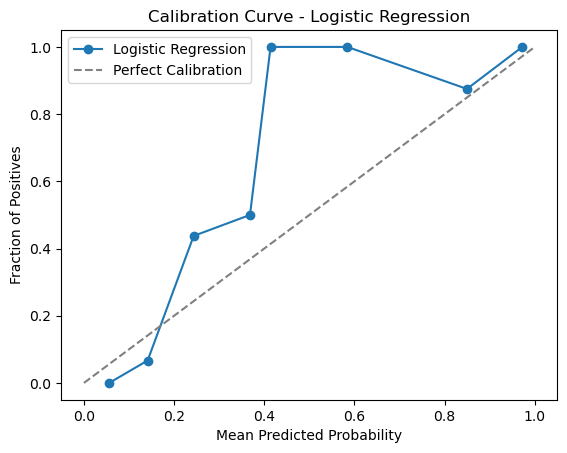

In [181]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Logistic Regression Model
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)

# Predictions and Probabilities
log_y_pred = log_model.predict(X_test)
log_y_pred_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
log_accuracy = accuracy_score(y_test, log_y_pred)
log_precision = precision_score(y_test, log_y_pred)
log_recall = recall_score(y_test, log_y_pred)
log_f1 = f1_score(y_test, log_y_pred)
log_roc_auc = roc_auc_score(y_test, log_y_pred_proba)

print(f"Logistic Regression - Accuracy: {log_accuracy:.2f}, Precision: {log_precision:.2f}, Recall: {log_recall:.2f}, F1 Score: {log_f1:.2f}, ROC-AUC: {log_roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression ROC Curve (AUC = {log_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, log_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression")
plt.legend()
plt.show()


## Naive Bayes

Naive Bayes - Accuracy: 0.83, Precision: 0.76, Recall: 0.99, F1 Score: 0.86, ROC-AUC: 0.86


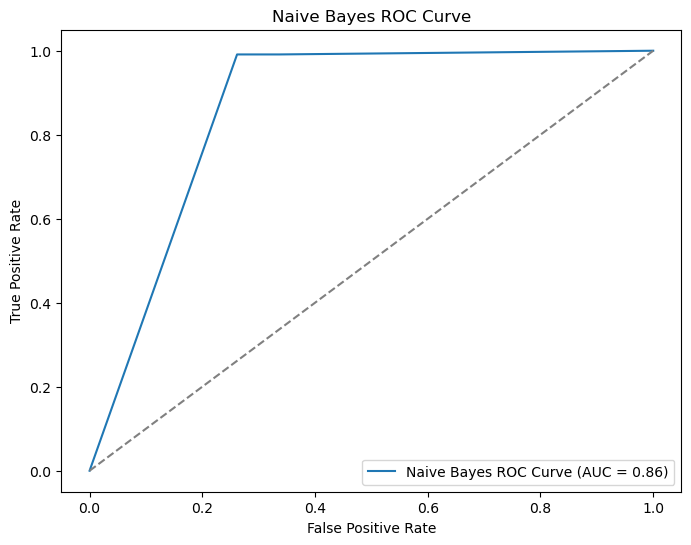

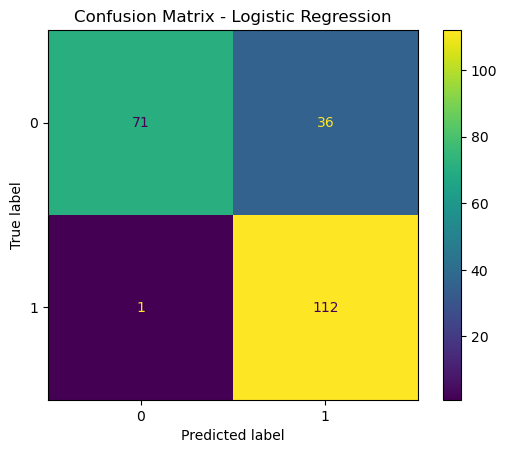

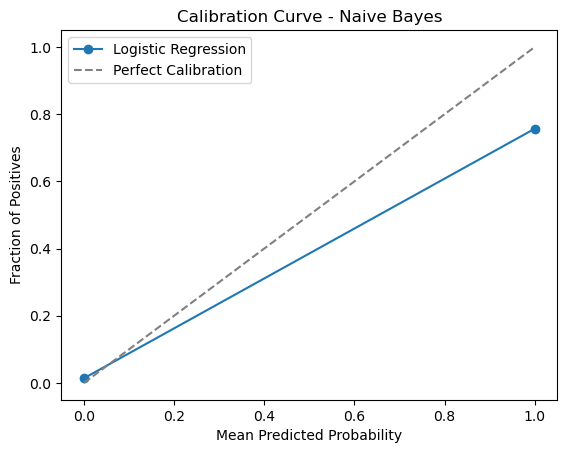

In [182]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions and Probabilities
nb_y_pred = nb_model.predict(X_test)
nb_y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)
nb_f1 = f1_score(y_test, nb_y_pred)
nb_roc_auc = roc_auc_score(y_test, nb_y_pred_proba)

print(f"Naive Bayes - Accuracy: {nb_accuracy:.2f}, Precision: {nb_precision:.2f}, Recall: {nb_recall:.2f}, F1 Score: {nb_f1:.2f}, ROC-AUC: {nb_roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, nb_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Naive Bayes ROC Curve (AUC = {nb_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, nb_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Naive Bayes")
plt.legend()
plt.show()


## Random Forest 

Random Forest - Accuracy: 0.91, Precision: 0.90, Recall: 0.92, F1 Score: 0.91, ROC-AUC: 0.95


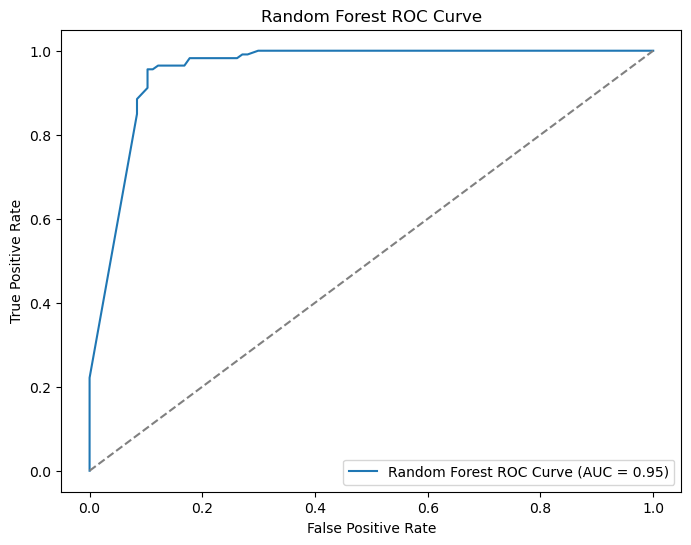

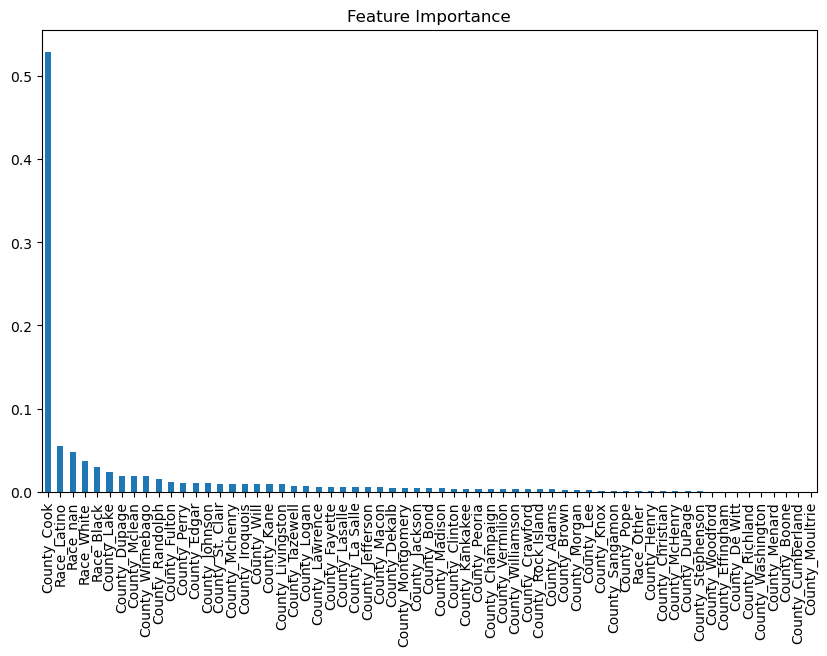

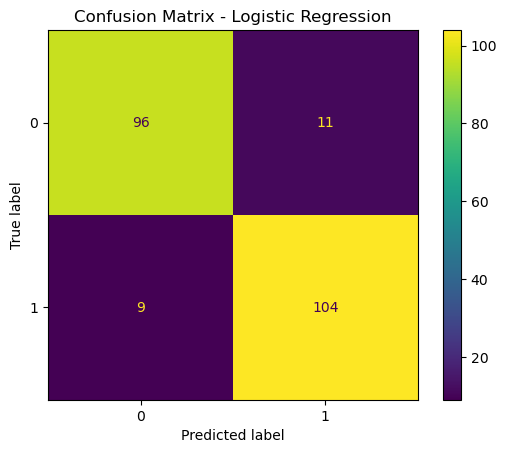

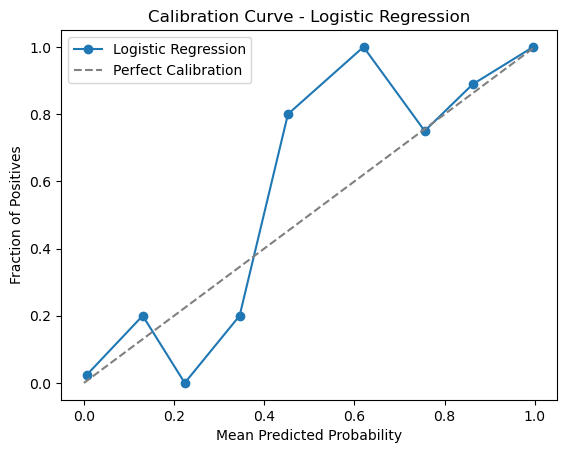

In [183]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Probabilities
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)

print(f"Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}, F1 Score: {rf_f1:.2f}, ROC-AUC: {rf_roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest ROC Curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', figsize=(10, 6), title="Feature Importance")
plt.show()

## Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, rf_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Logistic Regression")
plt.legend()
plt.show()



# KNN K nearest neighbores

In [184]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the range of 'n_neighbors' to test
param_grid = {'n_neighbors': range(1, 31)}  # Try k from 1 to 30

# Initialize the KNN model
knn = KNeighborsClassifier()

# Use GridSearchCV to find the optimal n_neighbors
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Get the best n_neighbors
best_n = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Optimal n_neighbors: {best_n}, Cross-Validation Accuracy: {best_score:.2f}")


Optimal n_neighbors: 1, Cross-Validation Accuracy: 0.89


KNN - Accuracy: 0.91, Precision: 0.87, Recall: 0.96, F1 Score: 0.92, ROC-AUC: 0.91


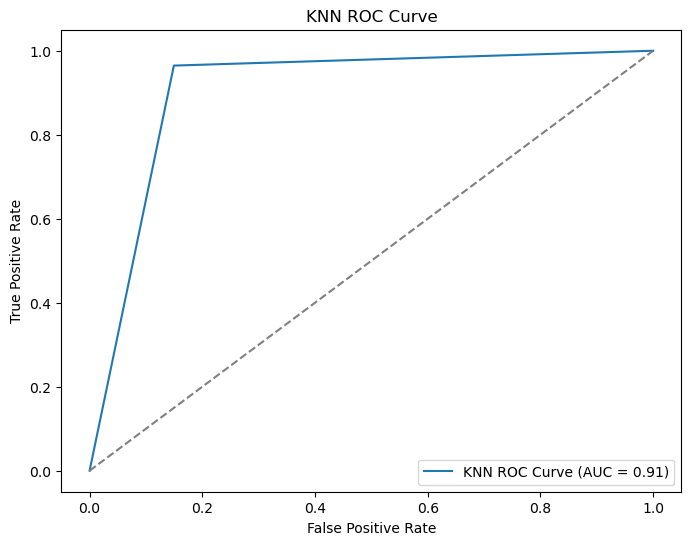

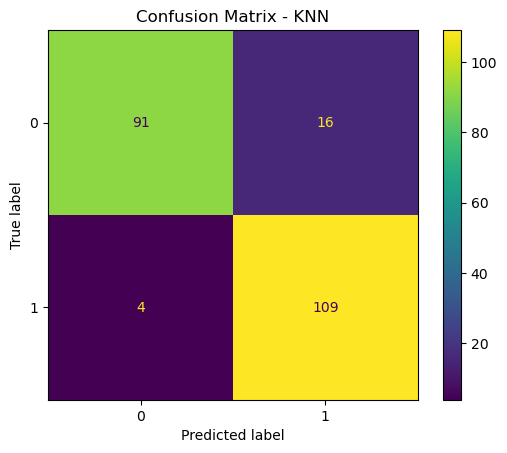

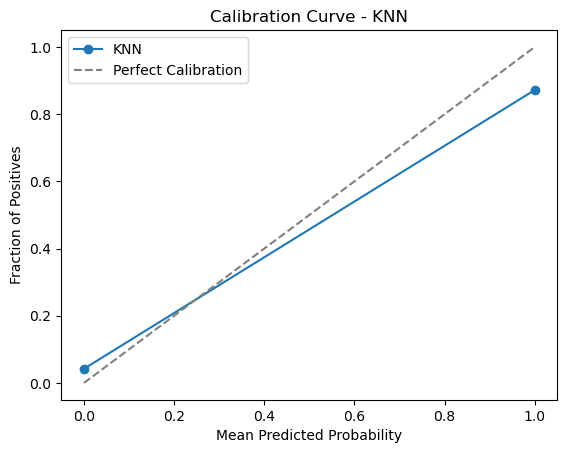

In [185]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=1)  # Adjust n_neighbors as needed
knn_model.fit(X_train, y_train)

# Predictions and Probabilities
knn_y_pred = knn_model.predict(X_test)
knn_y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred)
knn_roc_auc = roc_auc_score(y_test, knn_y_pred_proba)

print(f"KNN - Accuracy: {knn_accuracy:.2f}, Precision: {knn_precision:.2f}, Recall: {knn_recall:.2f}, F1 Score: {knn_f1:.2f}, ROC-AUC: {knn_roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, knn_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN ROC Curve (AUC = {knn_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.title("Confusion Matrix - KNN")
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, knn_y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label="KNN")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - KNN")
plt.legend()
plt.show()


## Model Comparisson

In [186]:
# Define metrics for each model
comparison_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Logistic Regression": [log_accuracy, log_precision, log_recall, log_f1, log_roc_auc],
    "Naive Bayes": [nb_accuracy, nb_precision, nb_recall, nb_f1, nb_roc_auc ],
    "Random Forest": [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc],
    "K-Nearest Neighbors": [knn_accuracy, knn_precision, knn_recall, knn_f1, knn_roc_auc]
}

# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)
# Style the DataFrame for better readability
comparison_df.style.set_caption("Model Comparison").highlight_max(axis=1, color="lightgreen")

# Display the table
comparison_df.head()


,Metric,Logistic Regression,Naive Bayes,Random Forest,K-Nearest Neighbors
0,Accuracy,0.895455,0.831818,0.909091,0.909091
1,Precision,0.901786,0.756757,0.904348,0.872000
2,Recall,0.893805,0.991150,0.920354,0.964602
3,F1 Score,0.897778,0.858238,0.912281,0.915966
4,ROC-AUC,0.952651,0.864403,0.954553,0.907535


## Visualizing Predicted Probability with Most Accurate Model 

In [187]:
# Predict probabilities for the test set
probabilities = rf_model.predict_proba(X_test)
# The second column contains the probabilities for the positive class (Exonerated)
exoneration_probabilities = probabilities[:, 1]

# Preview the first few probabilities
print(exoneration_probabilities[:10])


[1.         0.         0.86253375 0.         1.         0.86253375
 0.         0.7507617  0.86253375 0.        ]


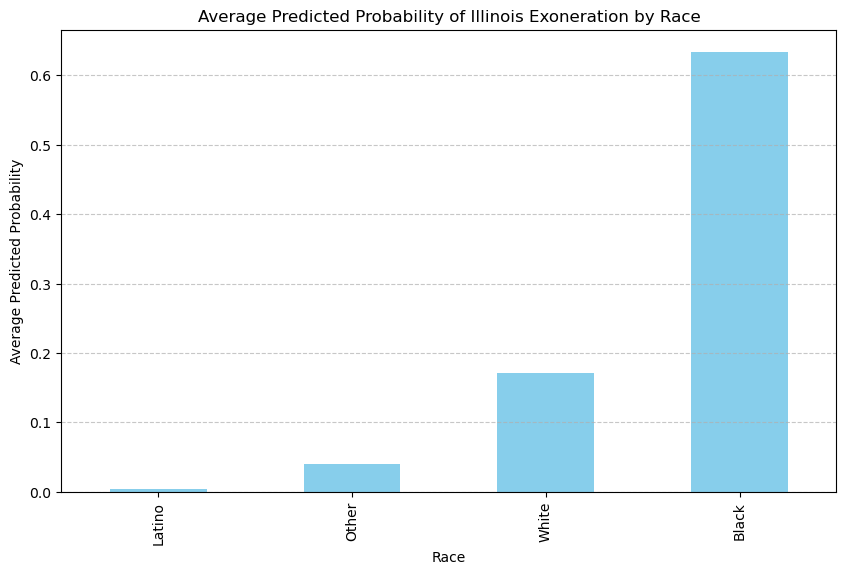

In [191]:
# Ensure X_test retains the one-hot encoded race columns
X_test_with_probabilities = X_test.copy()  # Create a copy of X_test
X_test_with_probabilities['exoneration_probability'] = exoneration_probabilities  # Add predicted probabilities

# Decode one-hot encoded race into a single column
race_columns = ['Race_Black', 'Race_Latino', 'Race_Other', 'Race_White']
X_test_with_probabilities['Race'] = X_test_with_probabilities[race_columns].idxmax(axis=1).str.replace('Race_', '')

# Group by race and calculate average probabilities
race_probabilities = X_test_with_probabilities.groupby('Race')['exoneration_probability'].mean()

# Plot the average probabilities for each race
race_probabilities.sort_values().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Predicted Probability of Illinois Exoneration by Race')
plt.xlabel('Race')
plt.ylabel('Average Predicted Probability')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



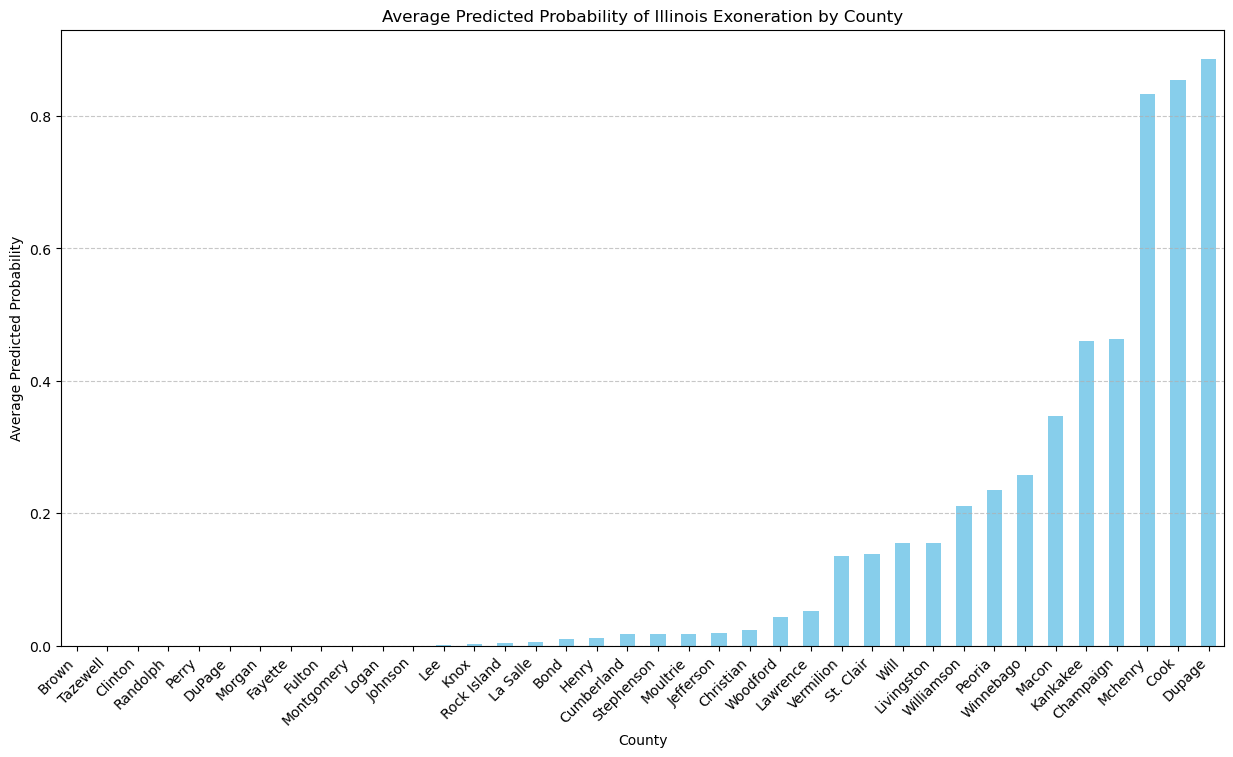

In [189]:
# Decode one-hot encoded county into a single column
county_columns = [col for col in X_test.columns if col.startswith('County_')]
for col in county_columns:
    county_name = col.replace('County_', '')
    X_test_with_probabilities.loc[X_test_with_probabilities[col] == 1, 'County'] = county_name

# Group by county and calculate average probabilities
county_probabilities = X_test_with_probabilities.groupby('County')['exoneration_probability'].mean()

# Plot the average probabilities for each county
county_probabilities.sort_values().plot(kind='bar', color='skyblue', figsize=(15, 8))
plt.title('Average Predicted Probability of Illinois Exoneration by County')
plt.xlabel('County')
plt.ylabel('Average Predicted Probability')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

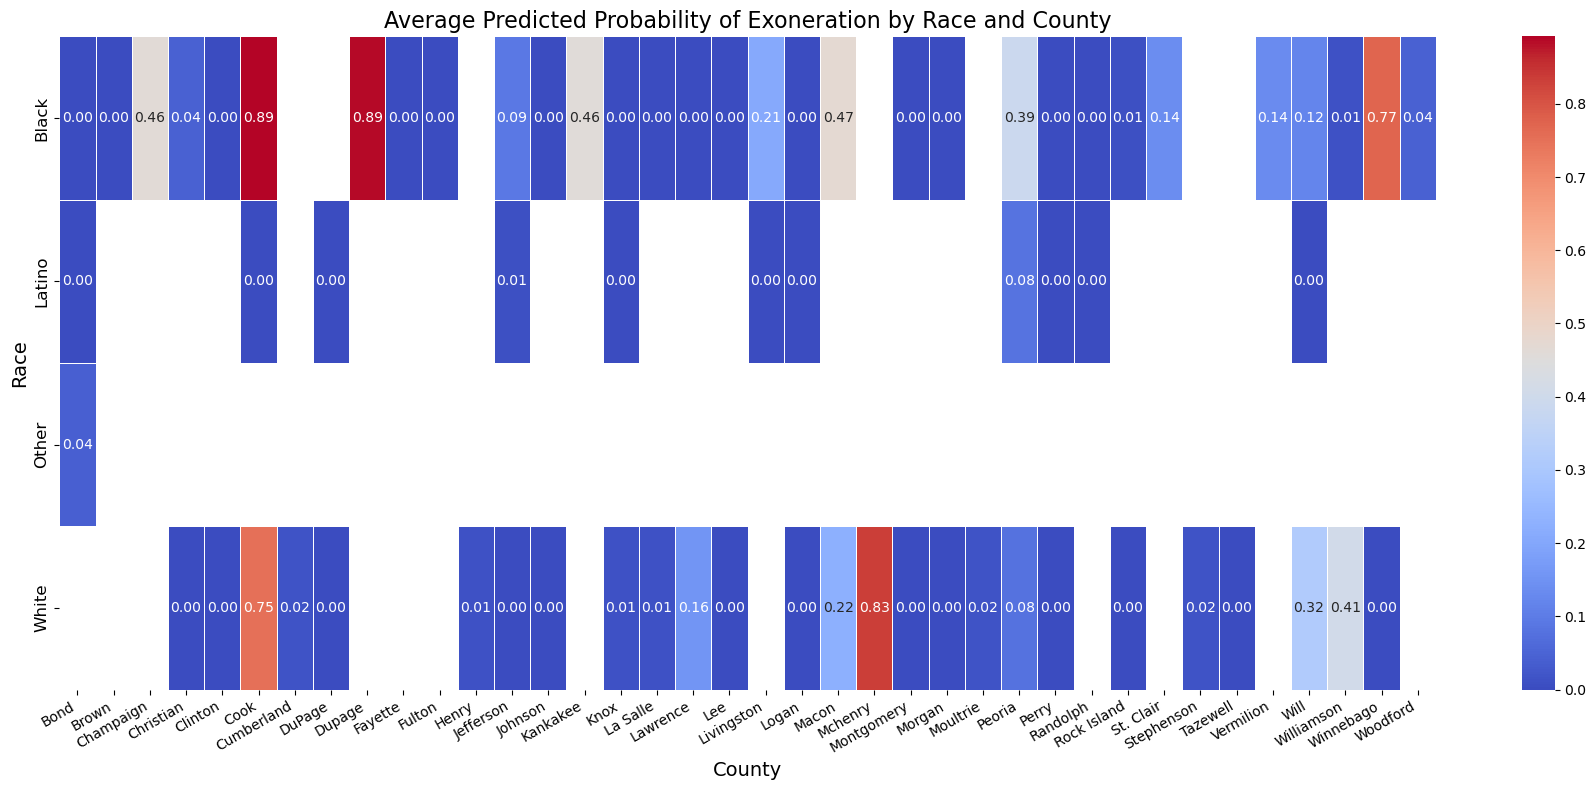

In [190]:
# Group by race and county, then calculate average probabilities
race_county_probabilities = X_test_with_probabilities.groupby(['Race', 'County'])['exoneration_probability'].mean().unstack()

# Plot a heatmap for race vs. county
import seaborn as sns
plt.figure(figsize=(18, 8))  # Increase width for better visibility

# Create the heatmap
sns.heatmap(
    race_county_probabilities,  # Assuming this is your DataFrame
    annot=True,  # Display numerical values
    fmt=".2f",  # Format the numbers to 2 decimal places
    cmap="coolwarm",  # Use a diverging colormap
    cbar=True,  # Display color bar
    linewidths=0.5  # Add spacing between cells
)

# Customize titles and labels
plt.title("Average Predicted Probability of Exoneration by Race and County", fontsize=16)
plt.xlabel("County", fontsize=14)
plt.ylabel("Race", fontsize=14)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=12)  # Increase font size for y-axis labels

# Display the heatmap
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()
